This code is made to analyze Pomodoro Techniques Logs and undersand how well Data Science with Python practice is going. 
Practice could be study, no profit project, work.

The goal is to reach 10.000 hours to be an expert. 
It's just a trivial proxy, but gives an idea and a direction and it's enough. 

The code is made to compare: 


*   How I am growing as Python Data Scientist after First Amazon Rejection
*   Setted how time still remains to become an expert based on 10.000 rule
*   2021 Projection with Quarters Forcast and their confidence level

#Library Autentication and Data Ingestion


In [1]:
#Google Drive Pre-work
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
#importing all the necessary libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import scipy.stats

##Autentication Section

In [3]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##Data Ingestion

In [4]:

#global variables of interest 

va='Python'
tvoi='Length'

#goal expressed in hours to be reached 
h=10000

#Link to the data source that is a csv file in drive
print("Please Insert the link to the Google Drive File")
namepath= input( )

id=namepath.split('/')[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  

# Dataset is now stored in a Pandas Dataframe
csvname="Filename.csv"
#read the csv
#The number of columns from the app csv file is known	
columns_name=['Year', 'Month', 'Day', 'Time', 'Length', 'Start', 'End', 'Activity']
dfraw=pd.read_csv(csvname,names=columns_name,sep=',',skiprows=1,skipfooter=0, index_col=False)
print("Printing the data type of the time variable:")
print(type(dfraw[tvoi].iloc[0]))
dfraw[tvoi] = dfraw[tvoi].astype('str')
#We throw away time variables longer than 6 characters
# 00:00:00 if there is any variable 
# longer should be an error
mask = (dfraw[tvoi].str.len() == 6) 
dfraw = dfraw.loc[mask]
#removing all the white spaces
dfraw[tvoi]=dfraw[tvoi].str.strip()
#Converting to datetime datatype the time column
dfraw[tvoi]=pd.to_datetime(dfraw[tvoi], format='%M:%S')
#Merging in one date thre columns containing
#Year Month Day Informations
dfraw['Date'] = dfraw.apply(lambda row: datetime(row['Year'], row['Month'], row['Day']), axis=1)


Please Insert the link to the Google Drive File
https://drive.google.com/file/d/1_fQkNzKlBjP7wLu8Rf-EUKOoZpFdTy81/view?usp=sharing
Printing the data type of the time variable:
<class 'str'>


In [5]:
#The code extracts all the logs containing the Python
#or python word
dfraw[['main_activity','sub_activity']]=dfraw['Activity'].str.split('@', 1,expand=True)
pythondf_raw=dfraw[(dfraw['Activity'].str.contains("Python",na=False)) | (dfraw['Activity'].str.contains("python",na=False))] 


## Resampling

In [6]:
#We create a copy of 
#the dataframe containing only the 
#python records and
#we aggregate on daily basis 


rs_df=pythondf_raw.groupby('Date').count().copy()
#We resample the dataframe in order to have 
#a continues time series 
#with daily frequency
#we fill missing values with 0
rs_df=rs_df.resample('D').asfreq().fillna(0)
#divide by 2 because each pomodoro record lasts 25 minutes
#and we create a new column to keep track of that
#NOTE!
#this transformation is needed 
#only for the Actual cumulated column
#not for the ideal one already expressed in terms of hours  
rs_df['Cum']=rs_df['Activity'].cumsum().divide(2)


#Plotting Functions

### Practice plot


In [7]:
#We create a function 
#in order to plot all the hours dedicated to the 
#Variable of Interest (in this specific case python)
#And we compare with the "hours per day  goal"

def practice_plot(df):
  progress=int(round(df.Cum[-1],0))
  max_hours=df['Cum'][-1]
  first_thous=df[df['Cum']>=1000].head(1)
  two_ths=df[df['Cum']>=1500]
  second_thous=df[df['Cum']>=2000].head(1)
  remaining_h=h-max_hours
  
  print("Remaining hours to became an expert: \n",remaining_h)
  print(type(df.index[0]))
  
  x_days=[df.index[0],first_thous.index[0],second_thous.index[0],df.index[-1]]
  x_days_label=[x.strftime("%d/%m/%Y") for x in x_days]
  
  fig2, ax2= plt.subplots(figsize=(6,4),
                          facecolor='white', dpi=300)
  #We plot and compare the actual trend
  #with the ideal    
  plt.axvline(first_thous.index,linestyle="dashed",color='lightgrey')
  plt.axvline(second_thous.index,linestyle="dashed",color='lightgrey')

  plt.axvline(df.index[-1],linestyle="dashed",color='navy')
  ax2.plot(df.index,rs_df['Cum'],color='navy')
  ax2.set_xticks([x_days[0],x_days[1],x_days[2],x_days[3]])
  ax2.tick_params(axis='y', colors='navy')
  ax2.set_xticklabels(["Start Date \n{}".format(x_days_label[0]),
                       x_days_label[1],
                       x_days_label[2],
                       "Last UpDate \n{}".format(x_days_label[3])], 
                      rotation=90,
                      color="navy")
  ax2.set_title('Total Python Experience\n Expressed in Hours Allocated',color="navy")

  limit=ax2.get_ylim()
  mid=limit[1]*0.10
  text=plt.text(x_days[1],mid,'1000h',fontsize=9,rotation=90,
               color="lightgrey"
              )
  text2=plt.text(x_days[2],mid,'2000h ',fontsize=9,rotation=90,
                color="lightgrey")
  text2=plt.text(x_days[-1],mid,"{}h".format(progress),fontsize=9,rotation=90,
                color="navy")
  ax2.set_ylabel("Hours",color='navy')
  ax2.spines['bottom'].set_color('navy')
  ax2.spines['top'].set_color('navy') 
  ax2.spines['right'].set_color('navy')
  ax2.spines['left'].set_color('navy')
  plt.show()


### Remaining Time To Become an Expert Plot Function

In [8]:

#creating a stacked barplot for experience
#rembember h is the 10.000 variable
def remaining_time(df):
  progress=int(round(df.Cum[-1],0))
  fig3, ax3= plt.subplots(figsize=(2,3),
                          facecolor='white', dpi=300)
  plt.bar(1,h,color="lightblue")
  plt.bar(1,h/2,color="#75bbfd")
  plt.bar(1,progress,color="navy")
  x1=[-2,-1,2,3,4]
  y1=[h,h,h,h,h]
  x3=x1
  y3=[x/2 for x in y1]
  pad=h*0.01
  prog_per=round(progress/10000*100,1)
  plt.hlines(h-40,x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
  plt.hlines(y3[0],x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
  plt.hlines(progress,x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
  ax3.xaxis.set_major_formatter(plt.NullFormatter())
  ax3.yaxis.set_major_formatter(plt.NullFormatter())
  ax3.spines['bottom'].set_color('navy')
  ax3.spines['top'].set_color('white') 
  ax3.spines['right'].set_color('white')
  ax3.spines['left'].set_color('white')
  ax3.tick_params(axis='x', colors='white')
  ax3.tick_params(axis='y', colors='white')
  #current expertise level
  plt.text(1.5,progress+pad,'Current Expertise Lev',
          fontsize=7,color="navy")
  #current value
  plt.text(1.5,progress-5*pad,'{} Hours'.format(progress),
         fontsize=7,color="navy")
  #master level
  plt.text(1.5,h+pad,'Master Lev.',
         fontsize=7,color="lightblue")
  #master value
  plt.text(1.5,h-5*pad,'10k Hours',
          fontsize=7,color="lightblue")
  #senior level
  plt.text(1.5,h/2+pad,'Senior Lev.',
          fontsize=7,color="#75bbfd")
  #senior value
  plt.text(1.5,h/2-5*pad,'5k Hours',
          fontsize=7,color="#75bbfd")
  annotation2=plt.annotate('', xy  = (0, h/2),  
     xycoords = 'data', \
     xytext = (0, h), textcoords = 'data', fontsize = 7, \
     color = '#303030', arrowprops=dict(edgecolor='lightblue', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
  txt1=plt.text(-2,progress+pad,'{}%'.format(prog_per),
          fontsize=7,color="navy")
  txt2=plt.text(-2,h/2+pad,'50%',
          fontsize=7,color="#75bbfd")
  txt3=plt.text(-2,h+pad,'100%',
          fontsize=7,color="lightblue")

  annotation2=plt.annotate('', xy  = (0, h/2),  
     xycoords = 'data', \
     xytext = (0, h), textcoords = 'data', fontsize = 7, \
     color = '#303030', arrowprops=dict(edgecolor='lightblue', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
  annotation3=plt.annotate('', xy  = (0, progress),  
     xycoords = 'data', \
     xytext = (0, h/2), textcoords = 'data', fontsize = 7, \
     color = '#303030', arrowprops=dict(edgecolor="#75bbfd", arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
  annotation4=plt.annotate('', xy  = (0, 0),  
     xycoords = 'data', \
     xytext = (0, progress), textcoords = 'data', fontsize = 7, \
      color = '#303030', arrowprops=dict(edgecolor='navy', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)              
  ax3.set_title("It's a long way to the Top\n if you want master the code",loc="left",fontsize=10,color='navy' )      
  

### Forcasting Plot Function

In [9]:

def marker_function(x_ax,y_ax,color_choice='yellow'):
  marker=plt.scatter(x_ax,y_ax,color=color_choice,marker="o") 
  return marker

def forecasting_2021_plot(df,forecast):
  progress=int(round(df.Cum[-1],0))
  quarter=["First Quarter","Second Quarter","Third Quarter","Fourth Quarter"] 
  forecast2021=forecast
  offset=timedelta(days=5)
  
  first_thous=df[df['Cum']>=1000].head(1)
  two_ths=df[df['Cum']>=1500]
  second_thous=df[df['Cum']>=2000].head(1)
  x_days=[df.index[0],first_thous.index[0],second_thous.index[0],df.index[-1]]
  x_days_label=[x.strftime("%d/%m/%Y") for x in x_days]
  first_quarter=forecast2021[forecast2021.ds<"31/03/2021"].iloc[-1]
  second_quarter=forecast2021[forecast2021.ds<"30/06/2021"].iloc[-1]
  third_quarter=forecast2021[forecast2021.ds<"30/09/2021"].iloc[-1]
  fourth_quarter=forecast2021[forecast2021.ds<"31/12/2021"].iloc[-1]
  quarter_forecast=[first_quarter.ds,second_quarter.ds,
                    third_quarter.ds,fourth_quarter.ds]
  quarter_values=[first_quarter.yhat,second_quarter.yhat,
                third_quarter.yhat,fourth_quarter.yhat] 
  quarter_label=[q+'\n'+qf.strftime("%d/%m/%Y") for q,qf in zip(quarter,quarter_forecast)]                             
  #AMZ Rejection
  #amz rejection
  first_rej=df.loc["2020-06-24":]
  y_amz=first_rej.index[(first_rej.index=="2020-06-24")
                  |(first_rej.index=="2020-12-04")
                 ]
  y_s=[x.date() for x in y_amz]
  
  
  x_vec=[x_days[2],x_days[3],
                 first_quarter.ds,second_quarter.ds,
                 third_quarter.ds,fourth_quarter.ds]
  y_vec=[df[df.index==x_days[2]]['Cum'].values,
         df[df.index==x_days[3]]['Cum'].values,
         first_quarter.yhat,second_quarter.yhat,
         third_quarter.yhat,fourth_quarter.yhat]
  y_vec_r=[int(x) for x in y_vec]
  fig2, ax2= plt.subplots(figsize=(6,4),
                          facecolor='white', dpi=300)
  plt.axvline(df.index[-1],linestyle="dashed",color='navy')
  ax2.plot(forecast2021.ds,forecast2021.yhat_upper,linestyle='dashed',color="#75bbfd")
  ax2.plot(forecast2021.ds,forecast2021.yhat,color="red")
  ax2.plot(forecast2021.ds,forecast2021.Costant,linestyle='dashed',color="#75bbfd")
  ax2.plot(two_ths.index,two_ths['Cum'],color='navy')
  ax2.set_xticks([x_days[2],x_days[3],
                 first_quarter.ds,second_quarter.ds,
                 third_quarter.ds,fourth_quarter.ds])
  ax2.tick_params(axis='y', colors='navy')
  ax2.set_xticklabels([x_days_label[2],
                     "Last UpDate \n{}".format(x_days_label[-1]),
                     quarter_label[0],quarter_label[1],
                     quarter_label[2],quarter_label[3]], 
                    rotation=90, color="lightgrey")
  ax2.set_title('2021 Forecasted Experience \n Expressed in Hours Allocated',color="navy")
  ax2.fill_between(forecast2021.ds,forecast2021.Costant, 
                   forecast2021.yhat,color='lavender')
  ax2.fill_between(forecast2021.ds,forecast2021.yhat_upper, 
                   forecast2021.yhat,color='aqua')
  ax2.set_ylabel("Hours",color='navy')
  ax2.vlines(x=x_vec,ymin=ax2.get_ylim()[0],
            ymax=y_vec,linestyle="dashed",color='navy')
  text2=plt.text(x_days[2]+timedelta(days=4.5),
                 1400,'2000h ',
                 fontsize=9,rotation=90,
                 color="lightgrey")
  #first_quarter_projection note
  first_quarter_projection=plt.text(x_days[2]+timedelta(days=4.5),
                                    1400,'2000h ',
                                    fontsize=9,rotation=90,
                                    color="lightgrey")
  #second_quarter_projection note
  second_quarter_projection=plt.text(x_days[2]+timedelta(days=4.5),
                                     1400,
                                     '2000h ',
                                     fontsize=9,
                                     rotation=90,
                                     color="lightgrey")
  #third_quarter_projection note
  third_quarter_projection=plt.text(x_days[2]+timedelta(days=4.5),
                                    1400,
                                    '2000h ',
                                    fontsize=9,
                                    rotation=90,
                                    color="lightgrey")
  #fourth_quarter_projection note
  fourth_quarter_projection=plt.text(x_days[2]+timedelta(days=4.5),
                                   1400,
                                   '2000h ',
                                   fontsize=9,
                                   rotation=90,
                                   color="lightgrey")
  ax2.scatter(x_vec,y_vec,color="yellow",marker="o")
  ax2.spines['bottom'].set_color('navy')
  ax2.spines['top'].set_color('navy') 
  ax2.spines['right'].set_color('navy')
  ax2.spines['left'].set_color('navy')
  plt.text(y_amz[0]+timedelta(days=-25),
           1500,
           'I Amazon Rejection',
           fontsize=9,
           rotation=90,
           color="darkgrey")
  plt.text(y_amz[1]+timedelta(days=-25),
           1500,
           'II Amazon Rejection',
           fontsize=9,
           rotation=90,
           color="lightgrey")

  yy=np.full(len(quarter_forecast),1500)
  x_off=[xx+offset for xx in quarter_forecast]
  int_quarter_values=[int(x) for x in quarter_values]
  str_quarter_values=["{}h".format(hh) for hh in int_quarter_values]

  for x_,y_,z_ in zip(x_off,yy,str_quarter_values):
    plt.text(x_,y_,z_,color='lightgrey',rotation=90)
  text_updtate=plt.text(x_days[-1]+offset,
                        1500,"{}h".format(progress),
                        fontsize=9,
                        rotation=90,
                        color="navy")

  plt.axvline(y_amz[0],linestyle="dashed", color='darkgrey')
  plt.axvline(y_amz[1],linestyle="dashed",color='lightgrey')
  plt.gca().get_xticklabels()[1].set_color('navy')
  plt.show()

###AMZ Rejection Plot Function


In [10]:
def the_rejection(df):
  #AMZ Rejection
  first_rej=df.loc["2020-06-24":]
  y_amz=first_rej.index[(first_rej.index=="2020-06-24")
                  |(first_rej.index=="2020-12-04")
                  |(first_rej.index==first_rej.index[-1])]
  
  x=np.arange(0,len(first_rej.index))
  y_s=[x.date() for x in y_amz]
  relative_sum=first_rej['Cum'][-1]-first_rej['Cum'][0]
  relative_sum_prc=round((first_rej['Cum'][-1]-first_rej['Cum'][0])/first_rej['Cum'][0]*100,1)
  b_rejection=df[df.index<="2020-06-24"].tail(20)
  fig2, ax2= plt.subplots(figsize=(6,4),
                          facecolor='white', dpi=300)
  
  fig2.subplots_adjust(top=0.9)
  #We plot and compare the actual trend
  x_l=first_rej.index[-1]+timedelta(days=30)
  x_g=first_rej.index[-1]+timedelta(days=1)
  x_gt=first_rej.index[-1]+timedelta(days=4.5)
  x_gn=first_rej.index[-1]+timedelta(days=-26)
  y_g=first_rej['Cum'][1]
  yy_g=first_rej['Cum'][-1]

  plt.axvline(y_amz[0],linestyle="dashed", color='darkgrey')
  plt.axvline(y_amz[1],linestyle="dashed",color='lightgrey')
  ax2.plot(b_rejection.index,b_rejection['Cum'],linestyle="dashed",color='indianred')
  ax2.plot(first_rej.index,first_rej['Cum'],color='red')
  ax2.set_xticks([y_amz[0],y_amz[1],y_amz[2]])
  ax2.set_xticklabels([y_s[0],y_s[1],"Last Update\n{}".format(y_s[2])],color='grey')
  ax2.set_xlim(right=x_l)
  limit=ax2.get_ylim()
  mid=(limit[1]+limit[0])/2
  plt.text(y_amz[0]+timedelta(days=-5),mid*0.91,'I Amazon Rejection',
          fontsize=7,rotation=90,color="darkgrey")
  plt.text(y_amz[1]+timedelta(days=-5),mid*0.91,'II Amazon Rejection',
          fontsize=7,rotation=90,color="lightgrey")
  annotation=plt.annotate('', xy  = (x_g, y_g),
                          xycoords = 'data', \
                          xytext = (x_g, yy_g), 
                          textcoords = 'data', 
                          fontsize = 7, \
                          color = '#303030', 
                          arrowprops=dict(edgecolor='red', arrowstyle = '<->', 
                                          shrinkA = 0, shrinkB = 0),)
  text=plt.text(x_gt,mid*0.91,
                'Delta between I rejection and last update ',
                fontsize=9,
                rotation=90,
                color="red",
                bbox=dict(facecolor='None', 
                          edgecolor='None'))
  text2=plt.text(x_gn,mid*0.99,
                 '+{}H\n+{}% '.format(relative_sum,relative_sum_prc),
                 fontsize=7,
                 bbox=dict(facecolor='navy', edgecolor='red'),
                 color="red")
  xtick=ax2.get_xticks()
  ax2.tick_params(axis='x',rotation=90,color='grey')
  ax2.tick_params(axis='y', colors='navy')
  ax2.yaxis.grid()
  ax2.set_ylabel("Hours",color='navy')
  ax2.set_title('Andrea Ciufo Python Experience Growth Trend',fontsize=14,
                pad=20,color="navy" )
  fig2.suptitle('+{} Hours +{}% Increased Knowledge since First Amazon Rejection'.
              format(relative_sum,relative_sum_prc), y=0.95, fontsize=8,color='navy')
  ax2.spines['bottom'].set_color('navy')
  ax2.spines['top'].set_color('navy') 
  ax2.spines['right'].set_color('navy')
  ax2.spines['left'].set_color('navy')
  plt.gca().get_xticklabels()[2].set_color('navy')
  plt.show()

#Andrea Ciufo Growth KPI Plotted




##Andrea Ciufo Growth After First AMZ Rejection

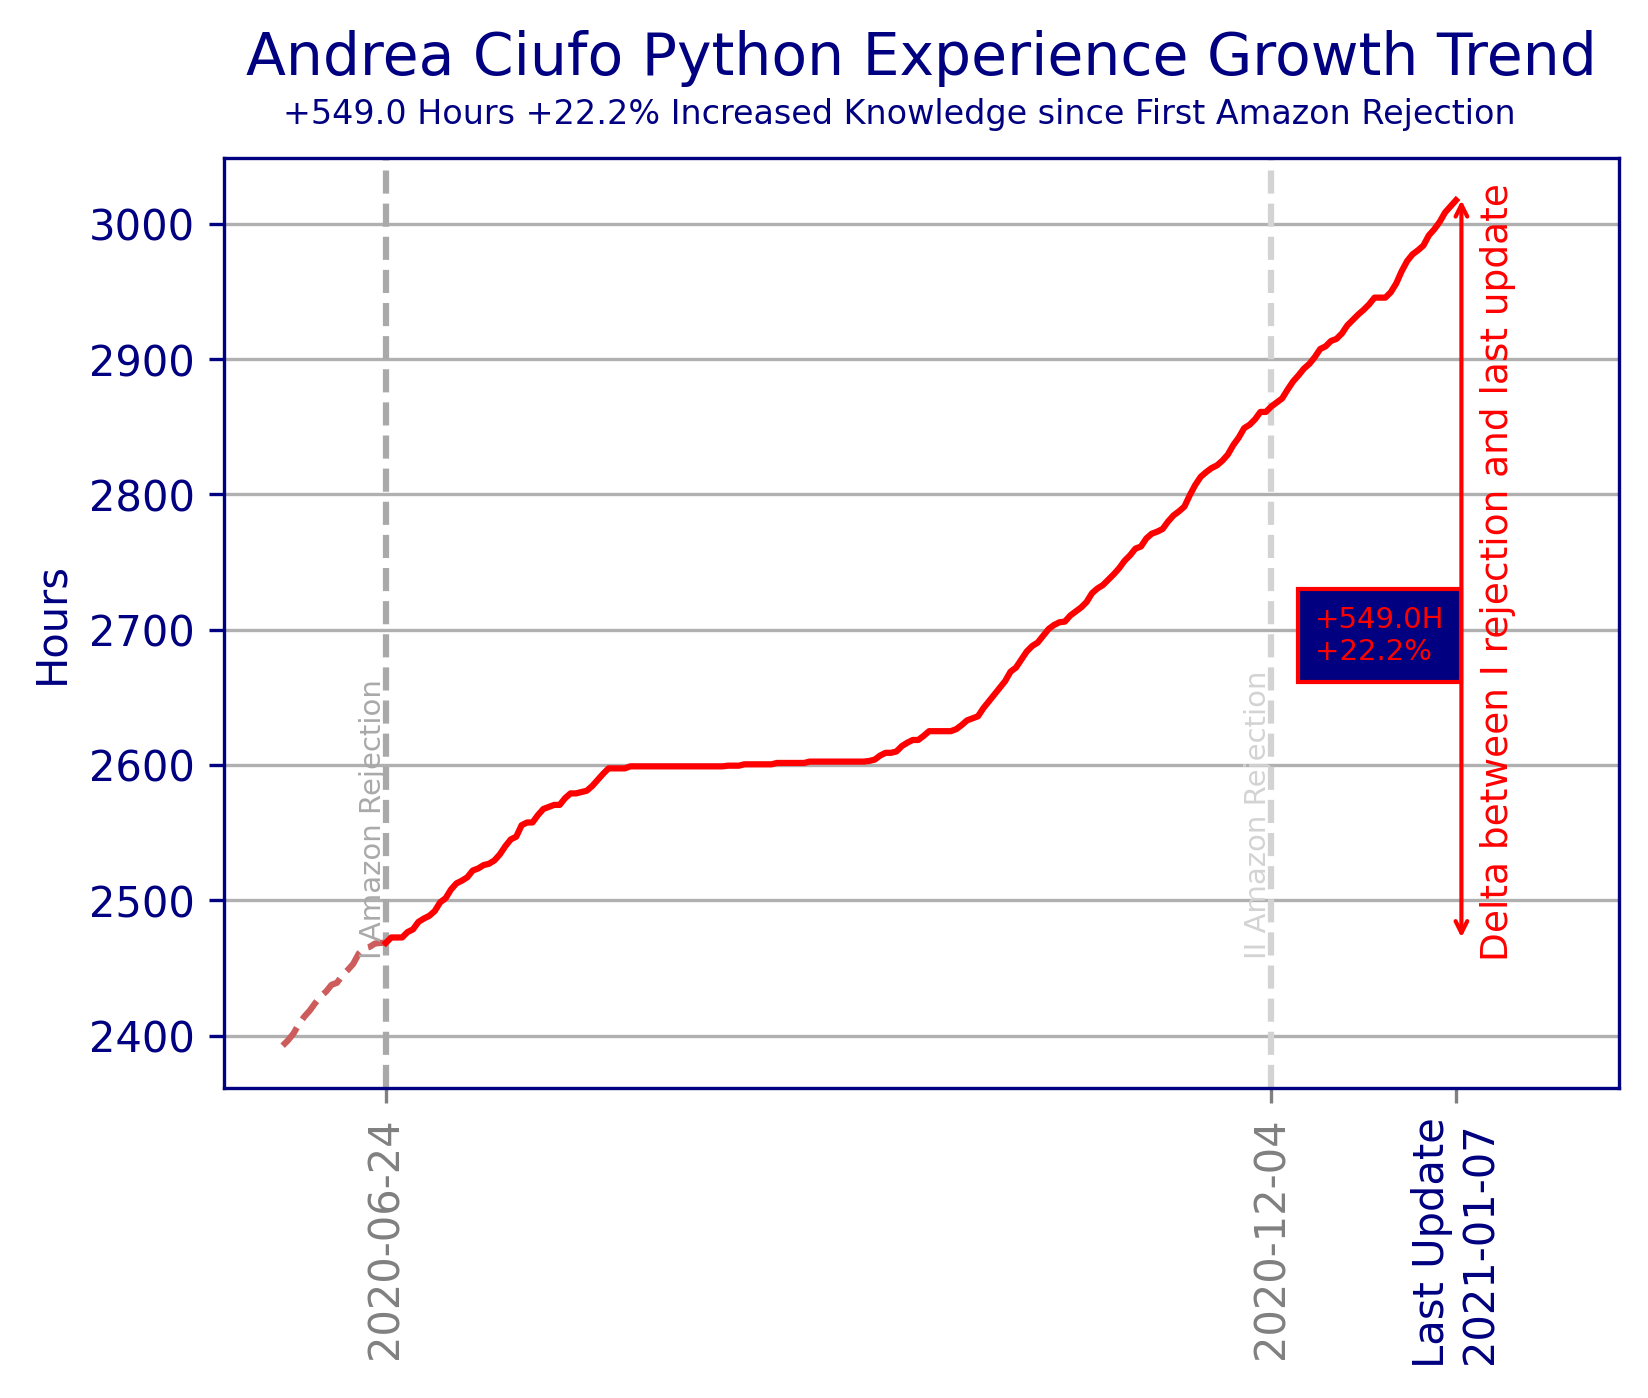

In [11]:
growth=the_rejection(rs_df)

##Andrea Ciufo Hours Remaining to be an expert

Total hours Dedicated until now 3017.5
Remaining hours to became an expert: 
 6982.5
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2021-01-07 00:00:00
datetime64[ns]
198


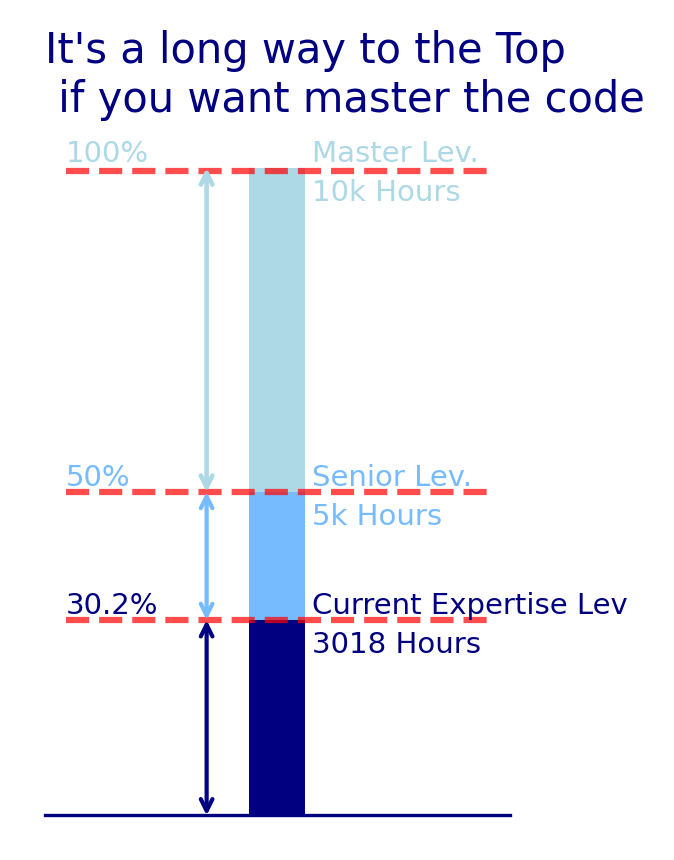

In [12]:
#Max Hours 
max_hours=rs_df['Cum'][-1]
print("Total hours Dedicated until now",max_hours)
remaining_h=h-max_hours
print("Remaining hours to became an expert: \n",remaining_h)
print(type(rs_df.index[0]))

first_rej=rs_df.loc["2020-06-24":]
print(first_rej.index[-1])
print(first_rej.index.dtype)
print(len(first_rej))
plot_bar=remaining_time(rs_df)

##Andrea Ciufo Absolute Growth Plot

Remaining hours to became an expert: 
 6982.5
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


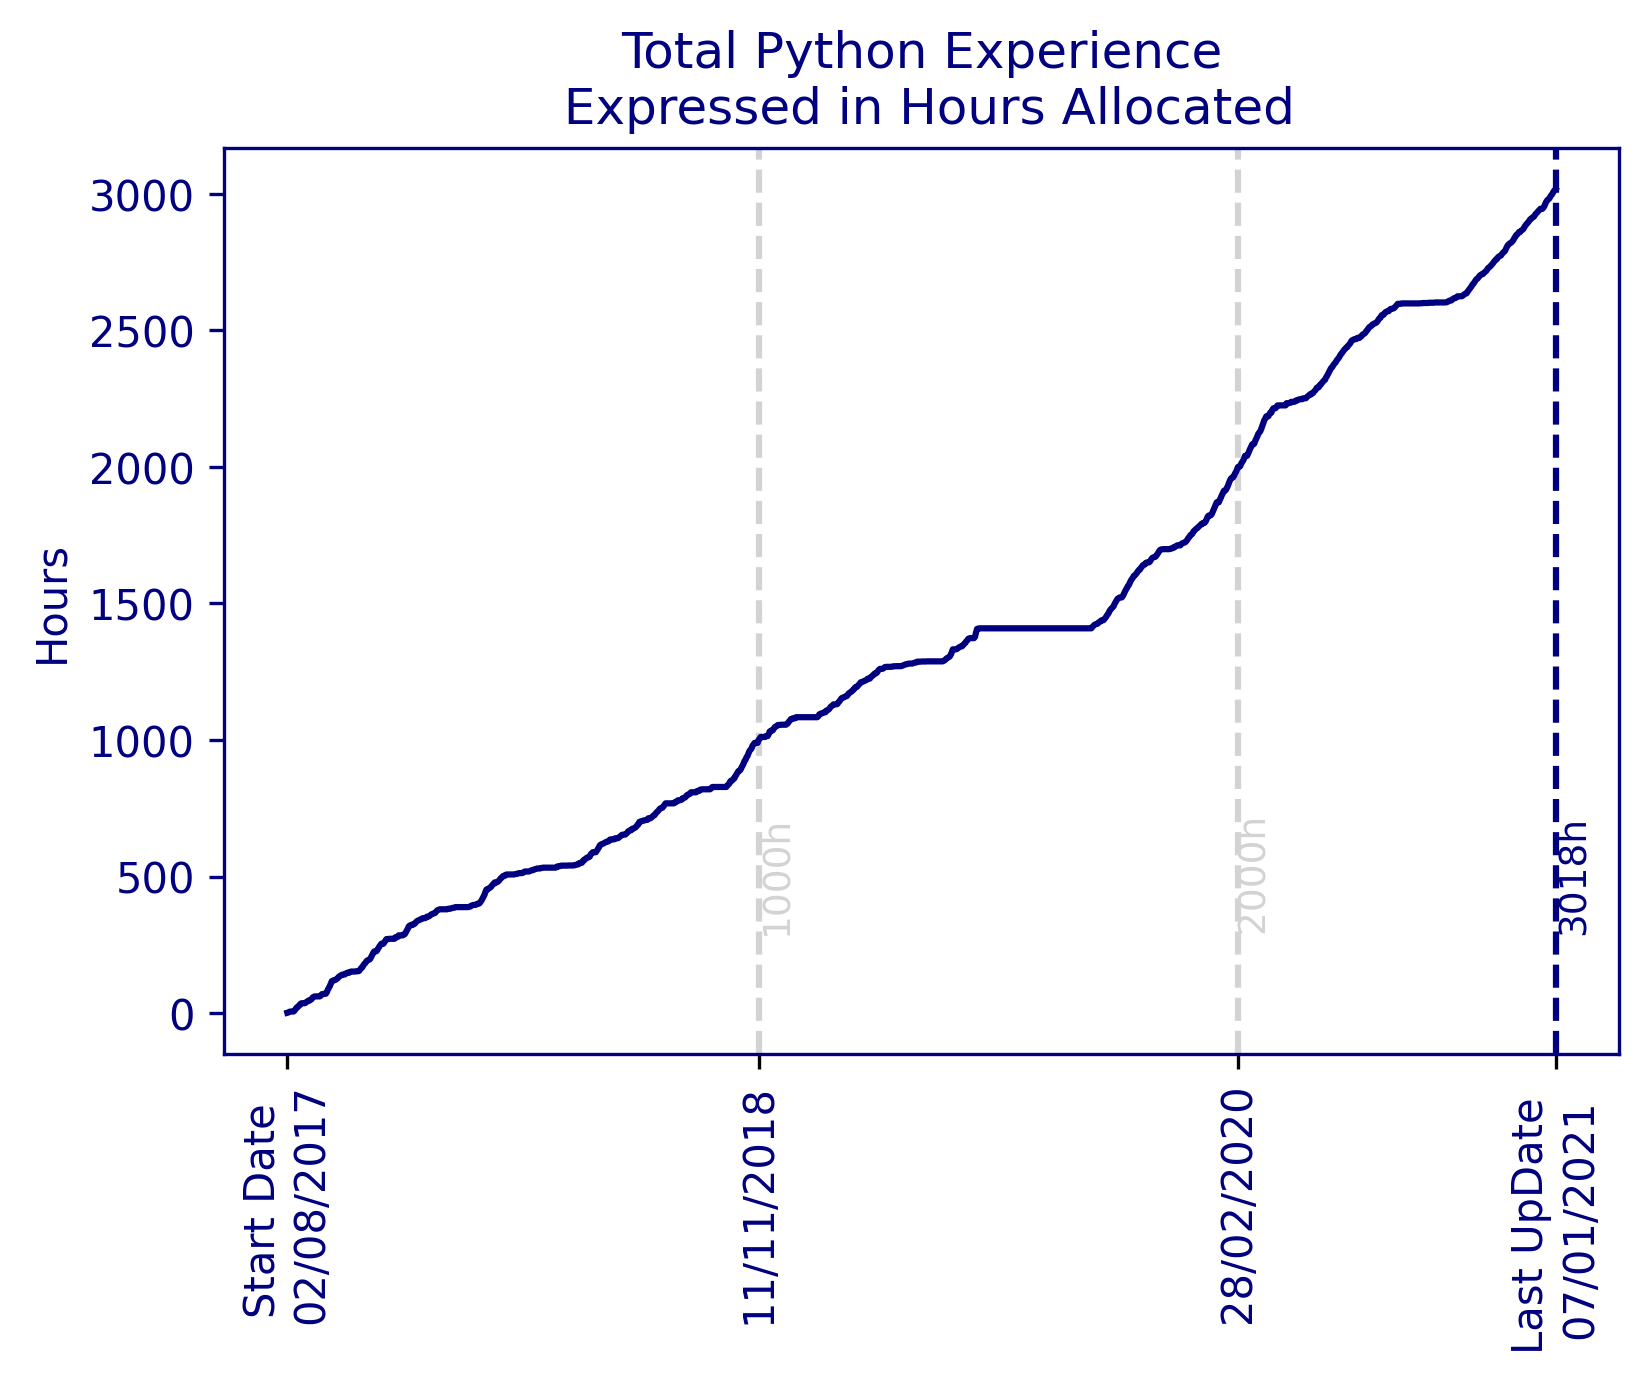

In [13]:
practice_plot(rs_df)

##Andrea Ciufo  Forcasting Using Prophet 

In [14]:
#Importing Prophet
from fbprophet import Prophet

In [15]:
#Creating the dictonary that we will use to ingest data
activity_column=rs_df.Cum.iloc[:,]
date_column=rs_df.index
dict_series={'ds':date_column,'y':activity_column} 
#creating today variable 
today=datetime.now()
actual_month=today.month
actual_year=today.year
#Creating the DataFrame that will be used as input for the 
#Prophet Model tuning 
prophet_df=pd.DataFrame(dict_series)

#Here we calculate the remaining days 
#to evaluate the how may days remain 
#at the end of the year 

#end of the year datetime 
end = datetime(datetime.today().year, 12, 31).date()
#today datetime 
today_datetime=today.date()
#
diff=(end-today_datetime).days
m = Prophet()
m.fit(prophet_df)
end_year=diff
future = m.make_future_dataframe(periods=diff)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#we should save the forecast containg in ds our evaluation day
last_forecast=forecast[['ds', 'yhat','yhat_lower',
                             'yhat_upper']].iloc[-1].copy()
print("Printing Last Forecast")
print(last_forecast)
print("Printing Tail")
print(forecast.tail())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Printing Last Forecast
ds            2021-12-31 00:00:00
yhat                      4261.98
yhat_lower                3001.72
yhat_upper                5579.92
Name: 1612, dtype: object
Printing Tail
             ds        trend  ...  multiplicative_terms_upper         yhat
1608 2021-12-27  4320.670769  ...                         0.0  4246.994151
1609 2021-12-28  4324.194162  ...                         0.0  4250.770861
1610 2021-12-29  4327.717554  ...                         0.0  4254.522265
1611 2021-12-30  4331.240946  ...                         0.0  4258.393721
1612 2021-12-31  4334.764339  ...                         0.0  4261.975463

[5 rows x 19 columns]


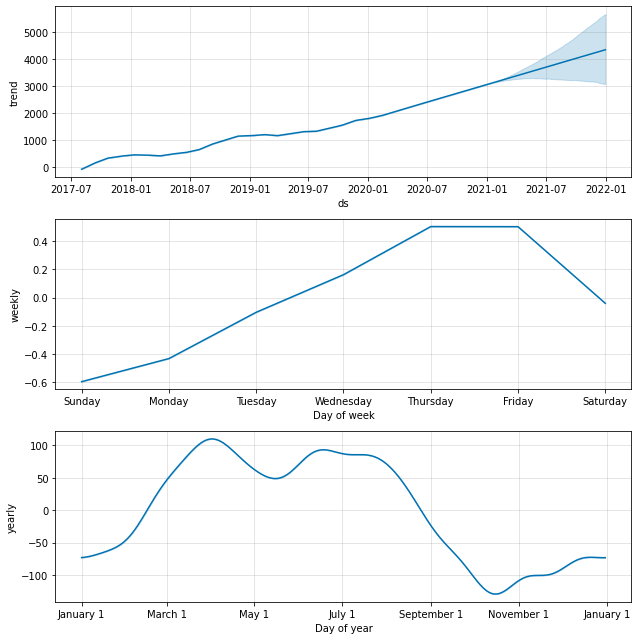

In [16]:
fig = m.plot_components(forecast)
plt.show()

### Forecasting a 6 years window using Prophet

ds            2027-01-06 00:00:00
yhat                        10718
yhat_lower               -9860.83
yhat_upper                30349.3
Name: 3444, dtype: object


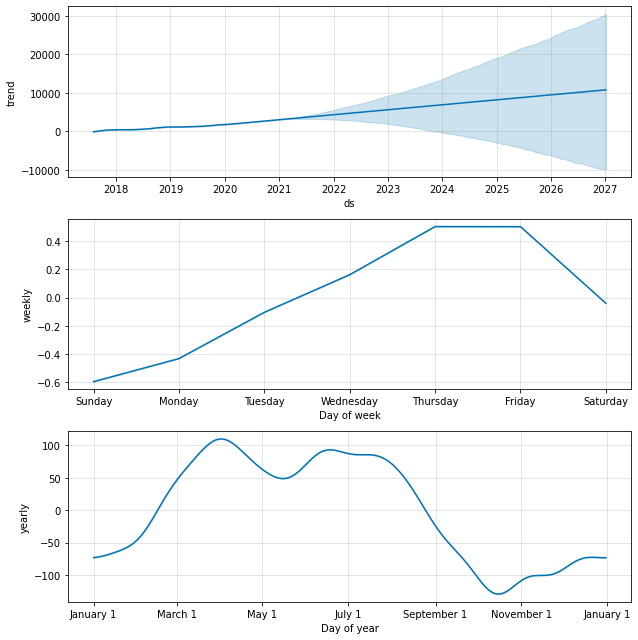

In [17]:
six_yw=365*6
future_6 = m.make_future_dataframe(periods=six_yw)
forecast_6 = m.predict(future_6)
forecast_6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#we should save the forecast containg in ds our evaluation day
last_forecast_6=forecast_6[['ds', 'yhat','yhat_lower',
                             'yhat_upper']].iloc[-1].copy()
print(last_forecast_6)
fig = m.plot_components(forecast_6)
plt.show()

In [18]:
rs_month=rs_df.resample('M').sum()
print(rs_month['main_activity'].tail())

Date
2020-09-30     36.0
2020-10-31    204.0
2020-11-30    262.0
2020-12-31    258.0
2021-01-31     74.0
Freq: M, Name: main_activity, dtype: float64


In [19]:

python_g=pythondf_raw.groupby('sub_activity').count().sort_values(by='main_activity',ascending=False)
print('Top 40 python activities')
print(python_g.head(40))
print('Last 30 python activities')
print(python_g.tail(30))

Top 40 python activities
                                                    Year  ...  main_activity
sub_activity                                              ...               
datacamp                                             592  ...            592
Lolacupcakes @work                                   533  ...            533
progetti                                             351  ...            351
bokeh @Lolacupcakes @timeseries @work                335  ...            335
aws @nsg @innlab                                     320  ...            320
statistics                                           256  ...            256
work @practice                                       249  ...            249
Rapporto Python                                      235  ...            235
pythonADSAPI                                         177  ...            177
theory&books @timeseries @study                      150  ...            150
studio @Tkinter                                    

##Andrea Ciufo 2021 Python Growth Forecast

In [20]:
forecasting2021=forecast_6[(forecast_6['ds']<'2022')&(forecast_6['ds']>rs_df.index[-1])]
forecasting2021=forecasting2021.assign(Costant=int(rs_df['Cum'][-1]))
forecasting2021=forecasting2021[['ds',"yhat_upper","yhat",'Costant']]


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



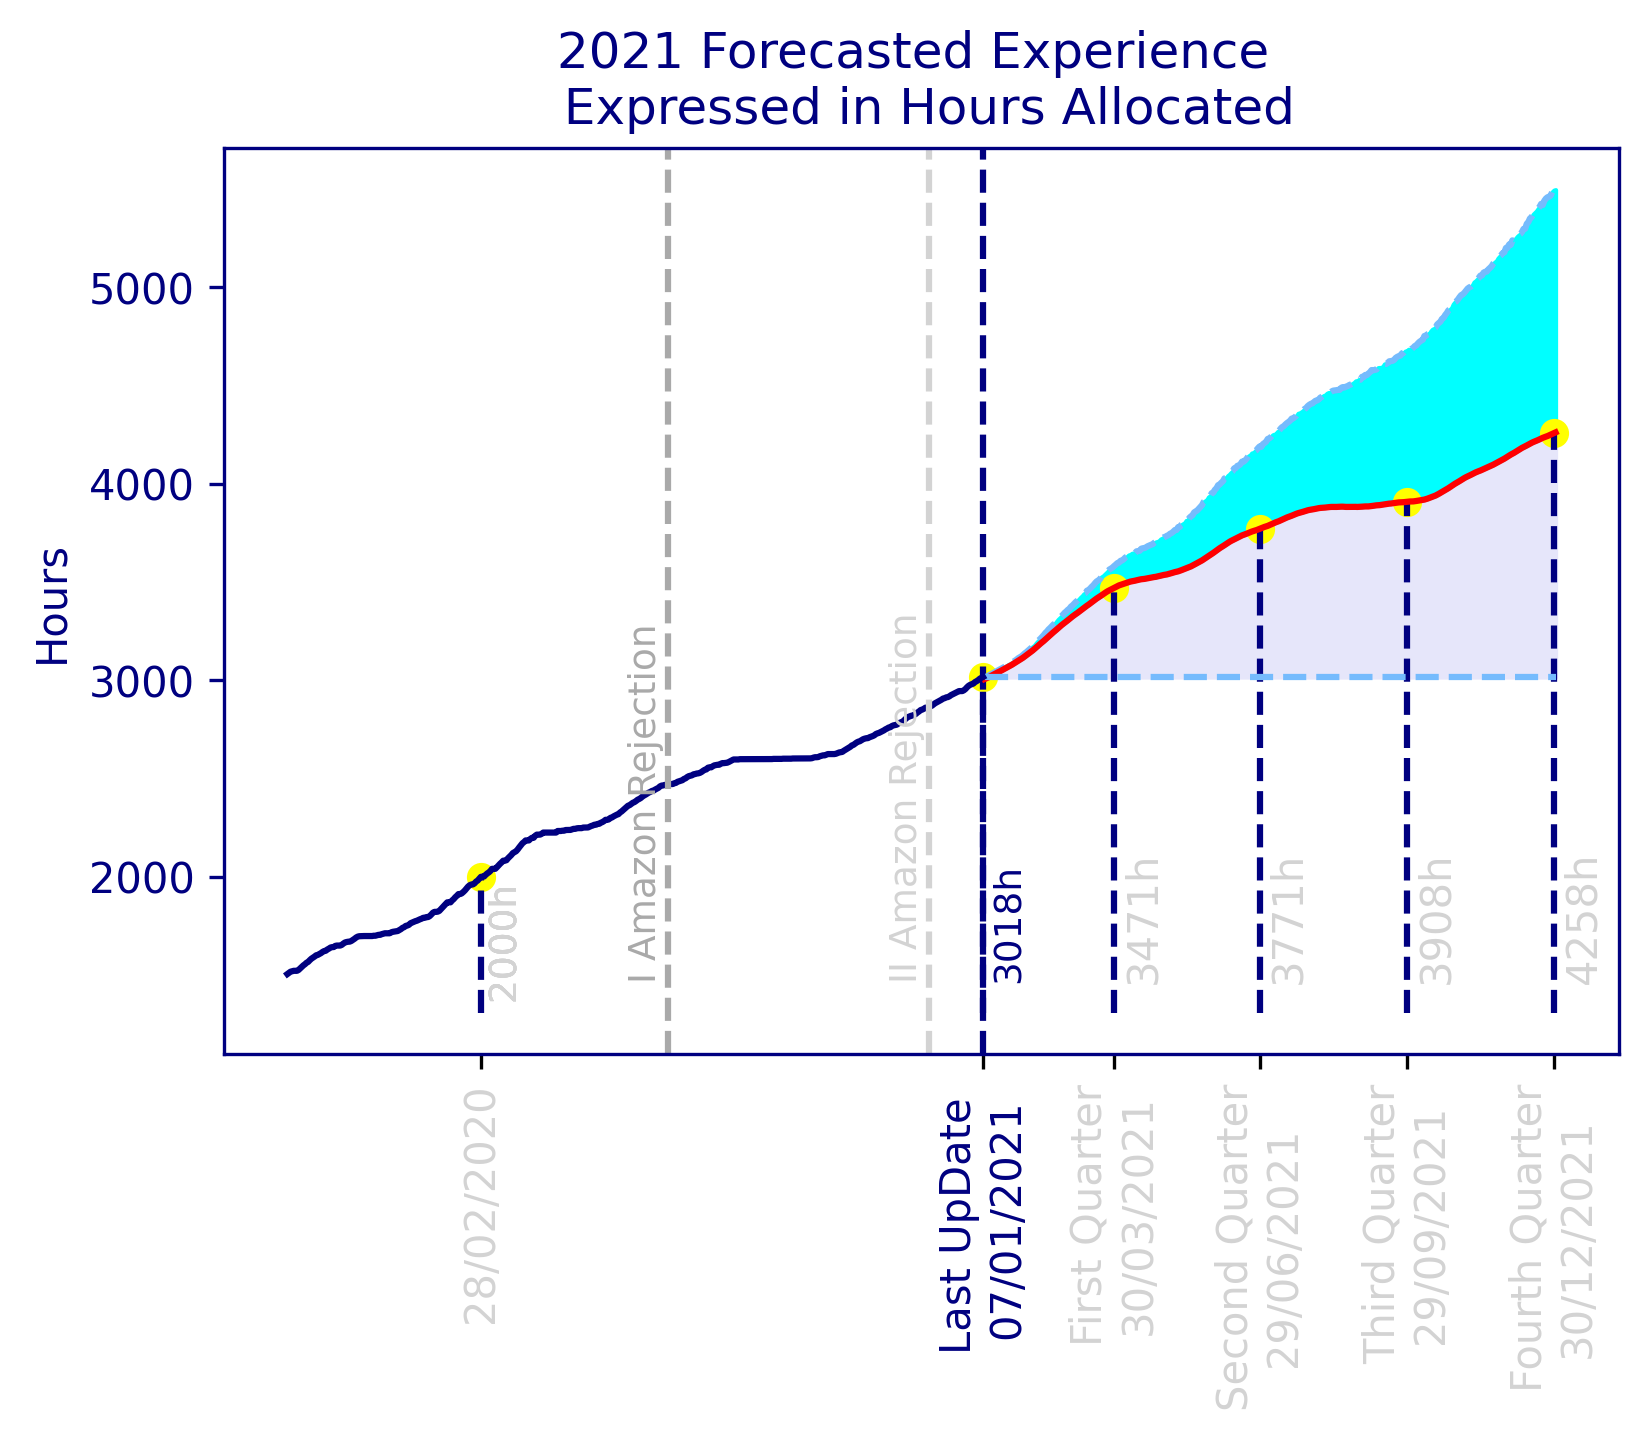

In [21]:
plotting_2021=forecasting_2021_plot(rs_df,forecasting2021)